In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform,randint
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/preprocess_data.csv',sep = ',')

In [3]:
pd.options.display.max_columns = None
data.head(5)

,Tournament,Home Team,Away Team,Match Date,Winner Team,Winner Home Or Away,Phase,Final Score,Extra Periods,Team,Opponent Team,Team Points,Team Two Pointers Made,Team Two Pointers Attempted,Team Two Pointers Percenage,Team Three Pointers Made,Team Three Pointers Attempted,Team Three Pointers Percenage,Team Free Throws Made,Team Free Throws Attempted,Team Free Throws Percenage,Team Offensive Rebounds,Team Defensive Rebounds,Team Total Rebounds,Team Assists,Team Steals,Team Turnovers,Team Blocks,Team Blocks Against,Team Personal Fouls,Team Fouls Received,Team Performance Index,Opponent Points,Opponent Two Pointers Made,Opponent Two Pointers Attempted,Opponent Two Pointers Percenage,Opponent Three Pointers Made,Opponent Three Pointers Attempted,Opponent Three Pointers Percenage,Opponent Free Throws Made,Opponent Free Throws Attempted,Opponent Free Throws Percenage,Opponent Offensive Rebounds,Opponent Defensive Rebounds,Opponent Total Rebounds,Opponent Assists,Opponent Steals,Opponent Turnovers,Opponent Blocks,Opponent Blocks Against,Opponent Personal Fouls,Opponent Fouls Received,Opponent Performance Index,Team Result,teamFGA,teamFGM,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamPoss,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,teamFIC,teamOrtg,opptFGA,opptPoss,teamDrtg,teamEDiff,team_Game_Score,opptFGM,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,oppt_Game_Score,Points difference,Finals,Last 32,Playoffs,Quarter-Finals,Regular Season,Semifinals,Top 16
0,Basket League,KAOD,Aris,2013-10-12,Aris,Away,Regular Season,58-66,0.0,KAOD,Aris,58.0,20.0,43.0,0.46512,1.0,10.0,0.10000,15.0,26.0,0.57692,12.0,22.0,34.0,6.0,6.0,17.0,3.0,3.0,22.0,22.0,40.0,66.0,15.0,33.0,0.45455,9.0,23.0,0.39130,9.0,19.0,0.47368,10.0,18.0,28.0,11.0,8.0,14.0,3.0,3.0,22.0,22.0,57.0,0.0,53.0,21.0,54.838710,28.571429,45.003104,40.566038,40.000000,68.750000,20.874263,69.44,8.640553,4.320276,9.090909,1.094340,36.206897,9.293680,0.352941,0.352941,24.000,83.525346,56.0,68.36,96.547689,-13.022343,26.4,24.0,45.161290,45.833333,51.274083,50.892857,31.250000,60.000000,17.866258,11.702750,4.388531,6.976744,1.178571,37.375,96.547689,83.525346,13.022343,40.000000,15.143172,0.785714,0.571429,39.8,-8.0,0,0,0,0,1,0,0
1,Basket League,PAOK,Kolossos Rhodes,2013-10-12,PAOK,Home,Regular Season,88-81,0.0,PAOK,Kolossos Rhodes,88.0,17.0,35.0,0.48571,10.0,26.0,0.38462,24.0,26.0,0.92308,9.0,22.0,31.0,22.0,7.0,18.0,3.0,1.0,23.0,23.0,96.0,81.0,26.0,42.0,0.61905,5.0,16.0,0.31250,14.0,21.0,0.66667,6.0,25.0,31.0,5.0,8.0,18.0,1.0,3.0,24.0,22.0,69.0,1.0,61.0,27.0,50.000000,81.481481,60.739923,52.459016,26.470588,78.571429,19.902698,81.44,8.595285,3.683694,7.142857,1.442623,38.571429,24.564538,1.222222,0.388889,60.500,108.055010,58.0,79.24,102.221100,5.833909,65.5,31.0,50.000000,16.129032,60.232005,57.758621,21.428571,73.529412,21.116847,10.095911,1.261989,2.857143,1.396552,38.375,102.221100,108.055010,-5.833909,44.285714,6.967670,0.277778,0.444444,46.3,7.0,0,0,0,0,1,0,0
2,Liga ACB,Bilbao,Zaragoza,2013-10-12,Zaragoza,Away,Regular Season,77-86,0.0,Bilbao,Zaragoza,77.0,24.0,46.0,0.52000,5.0,12.0,0.42000,14.0,20.0,0.70000,13.0,19.0,32.0,15.0,7.0,12.0,1.0,1.0,18.0,23.0,89.0,86.0,25.0,39.0,0.64000,10.0,23.0,0.43000,6.0,10.0,0.60000,9.0,20.0,29.0,16.0,10.0,10.0,1.0,1.0,23.0,18.0,95.0,0.0,58.0,29.0,52.459016,51.724138,57.634731,54.310345,39.393939,67.857143,15.228426,65.80,10.638298,1.519757,2.564103,1.327586,50.877193,19.685039,1.250000,0.583333,55.250,117.021277,62.0,67.40,127.596439,-10.575163,59.4,35.0,47.540984,45.714286,64.759036,64.516129,32.142857,60.606061,13.089005,14.836795,1.483680,2.173913,1.387097,65.250,127.596439,117.021277,10.575163,55.555556,19.138756,1.600000,1.000000,70.0,-9.0,0,0,0,0,1,0,0
3,Basket League,Trikala,Kifisia,2013-10-12,Kifisia,Away,Regular Season,64-69,0.0,Trikala,Kifisia,64.0,21.0,41.0,0.51220,

In [4]:
data["Tournament"].unique()

array(['Basket League', 'Liga ACB', 'Eurocup', 'Euroleague'], dtype=object)

# Teams as Dummy Variables

In [5]:
baseline_data = data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]]
baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Basket League,2013-10-12,KAOD,Aris,0.0,Aris,Regular Season
1,Basket League,2013-10-12,PAOK,Kolossos Rhodes,1.0,PAOK,Regular Season
2,Liga ACB,2013-10-12,Bilbao,Zaragoza,0.0,Zaragoza,Regular Season
3,Basket League,2013-10-12,Trikala,Kifisia,0.0,Kifisia,Regular Season
4,Liga ACB,2013-10-12,Tenerife,Obradoiro,1.0,Tenerife,Regular Season


## Greek Basket League 

In [6]:
greek_baseline_data = baseline_data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]][baseline_data["Tournament"]=='Basket League'].reset_index(drop = True)
greek_baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Basket League,2013-10-12,KAOD,Aris,0.0,Aris,Regular Season
1,Basket League,2013-10-12,PAOK,Kolossos Rhodes,1.0,PAOK,Regular Season
2,Basket League,2013-10-12,Trikala,Kifisia,0.0,Kifisia,Regular Season
3,Basket League,2013-10-13,Panelefsiniakos,Panionios,0.0,Panionios,Regular Season
4,Basket League,2013-10-13,Rethymno,Ikaros,1.0,Rethymno,Regular Season


In [7]:
greece_home = pd.get_dummies(greek_baseline_data["Home Team"]).reset_index(drop = True)
greece_away = -1*pd.get_dummies(greek_baseline_data["Away Team"]).reset_index(drop = True)
greece_x = pd.concat([greece_home,greece_away],axis=1).groupby(level=0, axis=1).sum()
greece_y = greek_baseline_data["Team Result"]

In [8]:
x_train_greece=greece_x.iloc[:len(greek_baseline_data[greek_baseline_data["Match Date"]<"2017-08-01"])]
y_train_greece=greece_y.iloc[:len(greek_baseline_data[greek_baseline_data["Match Date"]<"2017-08-01"])]
x_test_greece=greece_x.iloc[len(greek_baseline_data[greek_baseline_data["Match Date"]<"2017-08-01"]):]
y_test_greece=greece_y.iloc[len(greek_baseline_data[greek_baseline_data["Match Date"]<"2017-08-01"]):]

In [9]:
x_train_greece.shape

(825, 23)

###  Logistic Regression

In [14]:
lgr = LogisticRegression(C = 0.3839820885947254,penalty = 'l1', solver= 'liblinear').fit(x_train_greece, y_train_greece)
y_pre_proba_lgr=lgr.predict_proba(x_test_greece)
print("Logistic Regression")
print()
print("Test BS:",round(brier_score_loss(y_test_greece,y_pre_proba_lgr[:,1]),3))
print()
y_pre_lgr=np.where(pd.Series(y_pre_proba_lgr[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_lgr,y_test_greece),3))
print()
print("Test F1-score:",round(f1_score(y_pre_lgr,y_test_greece),3))


Logistic Regression

Test BS: 0.167

Test Accuracy: 0.735

Test F1-score: 0.806


In [11]:
coef_dict = {}
for coef, feat in zip(lgr.coef_[:].tolist()[0],greece_x.columns.values):
    coef_dict[feat] = coef
coef1=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef1=coef1.iloc[(-coef1[0].abs()).argsort()].reset_index()

In [12]:
sorted_coef1

,index,0
0,Olympiacos,3.764373
1,Panathinaikos,3.376631
2,AEK,1.483743
3,Aris,1.085436
4,PAOK,0.974255
5,Doxa Lefkadas,-0.689124
6,Panelefsiniakos,-0.466165
7,Kavala,-0.437357
8,Kolossos Rhodes,0.251653
9,Rethymno,0.224388


In [13]:
lgr.intercept_

array([0.81724341])

## Random Forest Classifier

In [14]:
rfc = RandomForestClassifier(max_depth= 38, max_features='sqrt', min_samples_leaf=0.0022712801155358453,
                             min_samples_split=0.009889030194338, n_estimators=53
                             ,random_state= 1).fit(x_train_greece, y_train_greece)

y_pre_proba_rfc=rfc.predict_proba(x_test_greece)
print("Random Forest Classifier")
print()
print("Test BS:",round(brier_score_loss(y_test_greece,y_pre_proba_rfc[:,1]),3))
print()
y_pre_rfc=np.where(pd.Series(y_pre_proba_rfc[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_rfc,y_test_greece),3))
print()
print("Test F1-score:",round(f1_score(y_pre_rfc,y_test_greece),3))

Random Forest Classifier

Test BS: 0.171

Test Accuracy: 0.745

Test F1-score: 0.814


In [15]:
coef_dict = {}
for coef, feat in zip(rfc.feature_importances_[:].tolist(),greece_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()
sorted_coef2

,index,0
0,Olympiacos,0.283394
1,Panathinaikos,0.234813
2,AEK,0.048400
3,Aris,0.036691
4,Panelefsiniakos,0.034729
5,PAOK,0.032931
6,Trikala,0.032928
7,Koroivos,0.030135
8,Apollon Patras,0.029540
9,Kifisia,0.026189


## xgboost

In [16]:
alg = XGBClassifier(colsample_bytree = 0.7120387144249468, gamma = 1.173482282705095, learning_rate = 0.18114216198386113,
                    max_depth= 41, n_estimators= 88, reg_lambda= 0.33962213881868086, subsample= 0.16627201904949962, 
                    objective='binary:logistic').fit(x_train_greece, y_train_greece)




y_pre_proba_alg=alg.predict_proba(x_test_greece)
print("xgboost")
print()
print("Test BS:",round(brier_score_loss(y_test_greece,y_pre_proba_alg[:,1]),3))
print()
y_pre_alg=np.where(pd.Series(y_pre_proba_alg[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_alg,y_test_greece),3))
print()
print("Test F1-score:",round(f1_score(y_pre_alg,y_test_greece),3))


xgboost

Test BS: 0.181

Test Accuracy: 0.735

Test F1-score: 0.804


In [18]:
coef_dict = {}
for coef, feat in zip(alg.feature_importances_[:].tolist(),greece_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()
sorted_coef3

,index,0
0,Doxa Lefkadas,0.098154
1,Promitheas Patras,0.080062
2,Olympiacos,0.073155
3,Kavala,0.066310
4,Panathinaikos,0.058280
5,Kolossos Rhodes,0.051872
6,PAOK,0.051035
7,Panelefsiniakos,0.049930
8,Ikaros,0.049473
9,Rethymno,0.048470


# Ensemble

In [19]:
ens_proba=(y_pre_proba_lgr[:,1]+y_pre_proba_rfc[:,1]+y_pre_proba_alg[:,1])/3


print("------Ensemble 3 classifier-------")
print()
print("Test BS:",round(brier_score_loss(y_test_greece,ens_proba),3))
print()
y_pre_ens=np.where(pd.Series(ens_proba)>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test_greece),3))
print()
print("Test F1-score:",round(f1_score(y_pre_ens,y_test_greece),3))


------Ensemble 3 classifier-------

Test BS: 0.171

Test Accuracy: 0.745

Test F1-score: 0.814


In [20]:
pd.options.display.max_rows = None
see_final_g=greek_baseline_data[["Home Team","Away Team","Team Result","Winner Team"]][greek_baseline_data["Match Date"]>"2017-08-01"]
see_final_g["prediction probability"]=ens_proba
see_final_g["RPS"]=(see_final_g["Team Result"]-see_final_g["prediction probability"])**2
see_final_g[see_final_g["RPS"]>0.5]

,Home Team,Away Team,Team Result,Winner Team,prediction probability,RPS
826,PAOK,Promitheas Patras,0.0,Promitheas Patras,0.835308,0.697740
829,Olympiacos,Panathinaikos,0.0,Panathinaikos,0.712732,0.507986
847,Rethymno,Lavrio,0.0,Lavrio,0.792145,0.627493
849,Kymi,Ifaistos Limnou,0.0,Ifaistos Limnou,0.719601,0.517825
867,Ifaistos Limnou,Rethymno,0.0,Rethymno,0.711670,0.506474
877,Trikala,Kymi,0.0,Kymi,0.756052,0.571615
879,AEK,Olympiacos,1.0,AEK,0.162049,0.702161
896,Ifaistos Limnou,Lavrio,0.0,Lavrio,0.714646,0.510719
901,PAOK,Olympiacos,1.0,PAOK,0.098046,0.813522
905,Koroivos,Kymi,0.0,Kymi,0.725635,0.526546


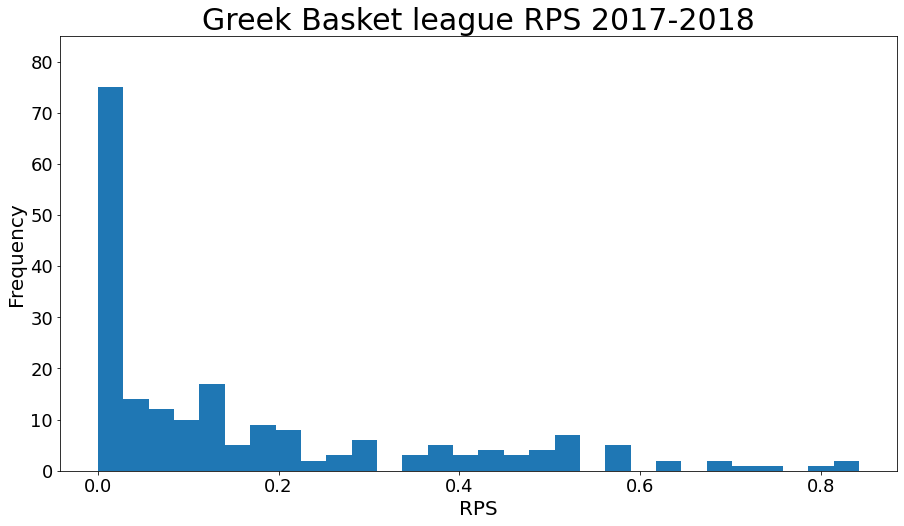

In [21]:
plt.figure(figsize=(15,8))



plt.hist(see_final_g["RPS"], 30, density=0)

plt.xlabel('RPS',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Greek Basket league RPS 2017-2018',fontsize=30)
plt.ylim(0,85)
plt.show()

In [22]:
greece_match_ups = greek_baseline_data[["Home Team","Away Team","Match Date","Winner Team"]][(greek_baseline_data["Match Date"]>'2017-08-01') & (greek_baseline_data["Tournament"]=='Basket League') & (greek_baseline_data["Phase"] == "Regular Season")]
greece_match_ups["Probability"] = ens_proba[:len(greece_match_ups)]
greece_match_ups["Winner Prediction"] = np.where(greece_match_ups["Probability"]>0.5,greece_match_ups["Home Team"],greece_match_ups["Away Team"])
greece_match_ups.head()

,Home Team,Away Team,Match Date,Winner Team,Probability,Winner Prediction
825,Kolossos Rhodes,Rethymno,2017-10-07,Kolossos Rhodes,0.721326,Kolossos Rhodes
826,PAOK,Promitheas Patras,2017-10-07,Promitheas Patras,0.835308,PAOK
827,Ifaistos Limnou,Panionios,2017-10-07,Ifaistos Limnou,0.629146,Ifaistos Limnou
828,AEK,Trikala,2017-10-07,AEK,0.926479,AEK
829,Olympiacos,Panathinaikos,2017-10-08,Panathinaikos,0.712732,Olympiacos


In [23]:
pd.crosstab(index=greece_match_ups["Winner Prediction"], columns="count").sort_values("count",ascending = False)

col_0,count
Winner Prediction,
Olympiacos,25
Panathinaikos,25
AEK,20
Aris,18
PAOK,18
Kolossos Rhodes,10
Rethymno,10
Ifaistos Limnou,8
Koroivos,8


In [24]:
pd.crosstab(index=greece_match_ups["Winner Team"], columns="count").sort_values("count",ascending = False)

col_0,count
Winner Team,
Panathinaikos,26
Olympiacos,22
PAOK,17
Promitheas Patras,17
AEK,15
Kymi,14
Lavrio,14
Kolossos Rhodes,11
Aris,10


# Liga ACB

In [25]:
spain_baseline_data = baseline_data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]][baseline_data["Tournament"]=='Liga ACB'].reset_index(drop = True)
spain_baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Liga ACB,2013-10-12,Bilbao,Zaragoza,0.0,Zaragoza,Regular Season
1,Liga ACB,2013-10-12,Tenerife,Obradoiro,1.0,Tenerife,Regular Season
2,Liga ACB,2013-10-13,Manresa,Joventut,1.0,Manresa,Regular Season
3,Liga ACB,2013-10-13,Baskonia,Gran Canaria,0.0,Gran Canaria,Regular Season
4,Liga ACB,2013-10-13,Gipuzkoa,Real Betis,1.0,Gipuzkoa,Regular Season


In [26]:
spain_home = pd.get_dummies(spain_baseline_data["Home Team"]).reset_index(drop = True)
spain_away = -1*pd.get_dummies(spain_baseline_data["Away Team"]).reset_index(drop = True)
spain_x = pd.concat([spain_home,spain_away],axis=1).groupby(level=0, axis=1).sum()
spain_y = spain_baseline_data["Team Result"]

In [27]:
spain_x.head()

,Andorra,Barcelona,Baskonia,Bilbao,Burgos,Estudiantes,Fuenlabrada,Gipuzkoa,Gran Canaria,Joventut,Manresa,Murcia,Obradoiro,Real Betis,Real Madrid,Tenerife,Unicaja Malaga,Valencia,Valladolid,Zaragoza
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0


In [28]:
x_train_spain=spain_x.iloc[:len(spain_baseline_data[spain_baseline_data["Match Date"]<"2017-08-01"])]
y_train_spain=spain_y.iloc[:len(spain_baseline_data[spain_baseline_data["Match Date"]<"2017-08-01"])]
x_test_spain=spain_x.iloc[len(spain_baseline_data[spain_baseline_data["Match Date"]<"2017-08-01"]):]
y_test_spain=spain_y.iloc[len(spain_baseline_data[spain_baseline_data["Match Date"]<"2017-08-01"]):]

###  Logistic Regression

In [29]:
lgr = LogisticRegression(solver='liblinear',C = 0.6783123387183132, penalty = 'l1').fit(x_train_spain, y_train_spain)
y_pre_proba_lgr=lgr.predict_proba(x_test_spain)
print("Logistic Regression")
print()
print("Test BS:",round(brier_score_loss(y_test_spain,y_pre_proba_lgr[:,1]),3))
print()
y_pre_lgr=np.where(pd.Series(y_pre_proba_lgr[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_lgr,y_test_spain),3))
print()
print("Test F1-score:",round(f1_score(y_pre_lgr,y_test_spain),3))


Logistic Regression

Test BS: 0.208

Test Accuracy: 0.682

Test F1-score: 0.764


In [30]:
coef_dict = {}
for coef, feat in zip(lgr.coef_[:].tolist()[0],spain_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()

In [31]:
sorted_coef2

,index,0
0,Real Madrid,2.087794
1,Valladolid,-1.910209
2,Barcelona,1.646865
3,Valencia,1.537073
4,Unicaja Malaga,1.021962
5,Manresa,-0.925369
6,Baskonia,0.835016
7,Gran Canaria,0.722133
8,Gipuzkoa,-0.517029
9,Estudiantes,-0.339469


In [32]:
lgr.intercept_

array([0.66249656])

## Random Forest Classifier

In [33]:
rfc = RandomForestClassifier(max_depth= 39, max_features='sqrt', min_samples_leaf=0.0009330471732301171,
                             min_samples_split=0.075312968832076, n_estimators=73,
                             random_state=1).fit(x_train_spain, y_train_spain)

y_pre_proba_rfc=rfc.predict_proba(x_test_spain)
print("Random Forest Classifier")
print()
print("Test BS:",round(brier_score_loss(y_test_spain,y_pre_proba_rfc[:,1]),3))
print()
y_pre_rfc=np.where(pd.Series(y_pre_proba_rfc[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_rfc,y_test_spain),3))
print()
print("Test F1-score:",round(f1_score(y_pre_rfc,y_test_spain),3))

Random Forest Classifier

Test BS: 0.208

Test Accuracy: 0.688

Test F1-score: 0.769


In [34]:
coef_dict = {}
for coef, feat in zip(rfc.feature_importances_[:].tolist(),spain_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()
sorted_coef2

,index,0
0,Real Madrid,0.208988
1,Valencia,0.124713
2,Barcelona,0.124122
3,Manresa,0.106363
4,Valladolid,0.062252
5,Unicaja Malaga,0.060946
6,Gipuzkoa,0.049874
7,Baskonia,0.040381
8,Gran Canaria,0.032876
9,Real Betis,0.031023


## xgboost

In [35]:
alg = XGBClassifier(colsample_bytree= 0.6188949028768943, gamma= 2.819830261508139, learning_rate= 0.36256801131990146,
                    max_depth= 21, n_estimators= 86, reg_lambda= 0.09211406347716067, subsample= 0.5079441274104476,
                    objective='binary:logistic').fit(x_train_spain, y_train_spain)

y_pre_proba_alg=alg.predict_proba(x_test_spain)
print("xgboost")
print()
print("Test BS:",round(brier_score_loss(y_test_spain,y_pre_proba_alg[:,1]),3))
print()
y_pre_alg=np.where(pd.Series(y_pre_proba_alg[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_alg,y_test_spain),3))
print()
print("Test F1-score:",round(f1_score(y_pre_alg,y_test_spain),4))


xgboost

Test BS: 0.218

Test Accuracy: 0.648

Test F1-score: 0.7332


In [36]:
coef_dict = {}
for coef, feat in zip(alg.feature_importances_[:].tolist(),spain_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()
sorted_coef3

,index,0
0,Gipuzkoa,0.072489
1,Real Madrid,0.070125
2,Manresa,0.066876
3,Valencia,0.064974
4,Baskonia,0.054553
5,Obradoiro,0.053784
6,Real Betis,0.053285
7,Fuenlabrada,0.051853
8,Bilbao,0.050135
9,Andorra,0.049760


In [37]:
ens_proba=(y_pre_proba_lgr[:,1]+y_pre_proba_rfc[:,1]+y_pre_proba_alg[:,1])/3


print("------Ensemble 3 classifier-------")
print()
print("Test BS:",round(brier_score_loss(y_test_spain,ens_proba),3))
print()
y_pre_ens=np.where(pd.Series(ens_proba)>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test_spain),3))
print()
print("Test F1-score:",round(f1_score(y_pre_ens,y_test_spain),3))


------Ensemble 3 classifier-------

Test BS: 0.209

Test Accuracy: 0.679

Test F1-score: 0.762


In [38]:
pd.options.display.max_rows = None
see_final_g=spain_baseline_data[["Home Team","Away Team","Team Result"]][spain_baseline_data["Match Date"]>"2017-08-01"]
see_final_g["prediction probability"]=ens_proba
see_final_g["RPS"]=(see_final_g["Team Result"]-see_final_g["prediction probability"])**2
see_final_g[see_final_g["RPS"]>0.5]

,Home Team,Away Team,Team Result,prediction probability,RPS
1291,Andorra,Fuenlabrada,0.0,0.723512,0.523470
1306,Burgos,Estudiantes,0.0,0.799082,0.638531
1318,Estudiantes,Barcelona,1.0,0.287337,0.507889
1331,Barcelona,Murcia,0.0,0.921935,0.849965
1332,Baskonia,Zaragoza,0.0,0.842825,0.710354
1335,Murcia,Obradoiro,0.0,0.721198,0.520127
1336,Unicaja Malaga,Baskonia,0.0,0.759868,0.577399
1349,Real Madrid,Barcelona,0.0,0.755873,0.571344
1371,Barcelona,Tenerife,0.0,0.900239,0.810431
1373,Estudiantes,Valencia,1.0,0.271829,0.530234


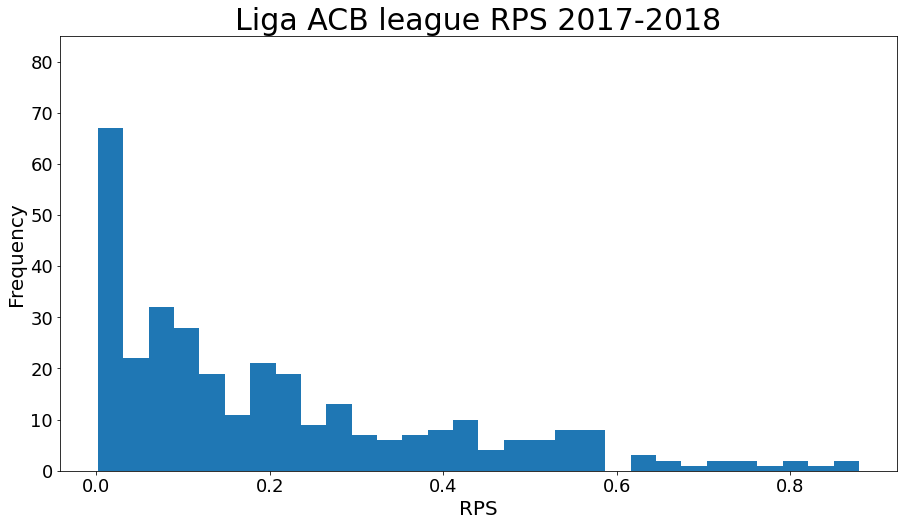

In [39]:
plt.figure(figsize=(15,8))

plt.hist(see_final_g["RPS"], 30, density=0)

plt.xlabel('RPS',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Liga ACB league RPS 2017-2018',fontsize=30)
plt.ylim(0,85)
plt.show()

In [40]:
spain_match_ups = spain_baseline_data[["Home Team","Away Team","Match Date","Winner Team"]][(spain_baseline_data["Match Date"]>'2017-08-01') & (spain_baseline_data["Tournament"]=='Liga ACB') & (spain_baseline_data["Phase"] == "Regular Season")]
spain_match_ups["Probability"] = ens_proba[:len(spain_match_ups)]
spain_match_ups["Winner Prediction"] = np.where(spain_match_ups["Probability"]>0.5,spain_match_ups["Home Team"],spain_match_ups["Away Team"])
spain_match_ups.head()

,Home Team,Away Team,Match Date,Winner Team,Probability,Winner Prediction
1280,Barcelona,Baskonia,2017-09-29,Barcelona,0.876098,Barcelona
1281,Obradoiro,Zaragoza,2017-09-30,Obradoiro,0.573751,Obradoiro
1282,Fuenlabrada,Bilbao,2017-09-30,Fuenlabrada,0.528257,Fuenlabrada
1283,Gran Canaria,Gipuzkoa,2017-10-01,Gran Canaria,0.834939,Gran Canaria
1284,Murcia,Unicaja Malaga,2017-10-01,Unicaja Malaga,0.433269,Unicaja Malaga


In [41]:
pd.crosstab(index=spain_match_ups["Winner Prediction"], columns="count").sort_values("count",ascending = False)

col_0,count
Winner Prediction,
Real Madrid,33
Valencia,30
Barcelona,30
Unicaja Malaga,27
Gran Canaria,23
Baskonia,21
Tenerife,17
Burgos,14
Joventut,13


In [42]:
pd.crosstab(index=spain_match_ups["Winner Team"], columns="count").sort_values("count",ascending = False)

col_0,count
Winner Team,
Real Madrid,30
Baskonia,25
Barcelona,24
Valencia,22
Gran Canaria,20
Andorra,19
Tenerife,19
Unicaja Malaga,19
Estudiantes,17


# Euroleague

In [43]:
el_baseline_data = baseline_data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]][baseline_data["Tournament"]=='Euroleague'].reset_index(drop = True)
el_baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Euroleague,2013-10-16,Bamberg,Strasbourg,1.0,Bamberg,Regular Season
1,Euroleague,2013-10-16,Siena,Galatasaray,0.0,Galatasaray,Regular Season
2,Euroleague,2013-10-17,Barcelona,Partizan,1.0,Barcelona,Regular Season
3,Euroleague,2013-10-17,Nanterre,CSKA Moscow,0.0,CSKA Moscow,Regular Season
4,Euroleague,2013-10-17,Anadolu Efes,Armani Milano,1.0,Anadolu Efes,Regular Season


In [44]:
el_home = pd.get_dummies(el_baseline_data["Home Team"]).reset_index(drop = True)
el_away = -1*pd.get_dummies(el_baseline_data["Away Team"]).reset_index(drop = True)
el_x = pd.concat([el_home,el_away],axis=1).groupby(level=0, axis=1).sum()
el_y = el_baseline_data["Team Result"]

In [45]:
el_x.head()

,Alba Berlin,Anadolu Efes,Armani Milano,Bamberg,Barcelona,Baskonia,Bayern Munich,Budivelnyk,CSKA Moscow,Cedevita,Crvena Zvezda,Darussafaka,Dinamo Sassari,Fenerbahce,Galatasaray,Khimki,Limoges,Lokomotiv Kuban,Maccabi Tel Aviv,Nanterre,Neptunas,Nizhny Novgorod,Olympiacos,Panathinaikos,Partizan,Pinar Karsiyaka,Real Madrid,Rytas Vilnius,Siena,Strasbourg,Turow Zgorzelec,Unicaja Malaga,Unics Kazan,Valencia,Zalgiris,Zielona Gora
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
x_train_el=el_x.iloc[:len(el_baseline_data[el_baseline_data["Match Date"]<"2017-08-01"])]
y_train_el=el_y.iloc[:len(el_baseline_data[el_baseline_data["Match Date"]<"2017-08-01"])]
x_test_el=el_x.iloc[len(el_baseline_data[el_baseline_data["Match Date"]<"2017-08-01"]):]
y_test_el=el_y.iloc[len(el_baseline_data[el_baseline_data["Match Date"]<"2017-08-01"]):]

###  Logistic Regression

In [47]:
lgr = LogisticRegression(solver='liblinear' , C= 0.7847137962592965, penalty='l1').fit(x_train_el, y_train_el)
y_pre_proba_lgr=lgr.predict_proba(x_test_el)
print("Logistic Regression")
print()
print("Test BS:",round(brier_score_loss(y_test_el,y_pre_proba_lgr[:,1]),3))
print()
y_pre_lgr=np.where(pd.Series(y_pre_proba_lgr[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_lgr,y_test_el),3))
print()
print("Test F1-score:",round(f1_score(y_pre_lgr,y_test_el),3))


Logistic Regression

Test BS: 0.215

Test Accuracy: 0.65

Test F1-score: 0.745


In [48]:
coef_dict = {}
for coef, feat in zip(lgr.coef_[:].tolist()[0],el_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()

In [49]:
sorted_coef3.head(50)

,index,0
0,Dinamo Sassari,-1.927399
1,CSKA Moscow,1.891682
2,Fenerbahce,1.459229
3,Real Madrid,1.429652
4,Olympiacos,1.280449
5,Barcelona,1.097557
6,Lokomotiv Kuban,0.935592
7,Zielona Gora,-0.830942
8,Turow Zgorzelec,-0.804748
9,Rytas Vilnius,-0.706639


In [50]:
lgr.intercept_

array([0.63201405])

## Random Forest Classifier

In [51]:
rfc = RandomForestClassifier(max_depth= 36, max_features='log2', min_samples_leaf=0.002390948900012013,
                             min_samples_split=0.0096605683266830, n_estimators=73,
                             random_state=1).fit(x_train_el, y_train_el)

y_pre_proba_rfc=rfc.predict_proba(x_test_el)
print("Random Forest Classifier")
print()
print("Test BS:",round(brier_score_loss(y_test_el,y_pre_proba_rfc[:,1]),3))
print()
y_pre_rfc=np.where(y_pre_proba_rfc[:,1] > 0.5, 1, 0)
print("Test Accuracy:",round(accuracy_score(y_pre_rfc ,y_test_el),3))
print()
print("Test F1-score:",round(f1_score(y_pre_rfc,y_test_el),3))

Random Forest Classifier

Test BS: 0.213

Test Accuracy: 0.665

Test F1-score: 0.767


In [52]:
coef_dict = {}
for coef, feat in zip(rfc.feature_importances_[:].tolist(),el_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()
sorted_coef2

,index,0
0,CSKA Moscow,0.168744
1,Fenerbahce,0.090365
2,Real Madrid,0.088042
3,Olympiacos,0.063474
4,Dinamo Sassari,0.059923
5,Barcelona,0.045307
6,Cedevita,0.041240
7,Zielona Gora,0.035126
8,Zalgiris,0.033663
9,Panathinaikos,0.029646


## xgboost

In [53]:
alg = XGBClassifier(colsample_bytree= 0.897167919370632, gamma= 0.835671500072126, learning_rate= 0.3887154858505634,
                    max_depth= 1, n_estimators= 99, reg_lambda= 0.7909237442174416, subsample= 0.963659261900305,
                    objective='binary:logistic').fit(x_train_el, y_train_el)

y_pre_proba_alg=alg.predict_proba(x_test_el)
print("xgboost")
print()
print("Test BS:",round(brier_score_loss(y_test_el,y_pre_proba_alg[:,1]),3))
print()
y_pre_alg=np.where(y_pre_proba_alg[:,1] > 0.5, 1, 0)
print("Test Accuracy:",round(accuracy_score(y_pre_alg ,y_test_el),3))
print()
print("Test F1-score:",round(f1_score(y_pre_alg,y_test_el),3))


xgboost

Test BS: 0.215

Test Accuracy: 0.65

Test F1-score: 0.756


In [54]:
coef_dict = {}
for coef, feat in zip(alg.feature_importances_[:].tolist(),el_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()
sorted_coef3

,index,0
0,CSKA Moscow,0.086758
1,Real Madrid,0.080293
2,Fenerbahce,0.062726
3,Olympiacos,0.058604
4,Cedevita,0.055974
5,Panathinaikos,0.048450
6,Dinamo Sassari,0.048178
7,Zalgiris,0.047269
8,Zielona Gora,0.047133
9,Barcelona,0.042192


In [55]:
ens_proba=(y_pre_proba_lgr[:,1]+y_pre_proba_rfc[:,1]+y_pre_proba_alg[:,1])/3


print("------Ensemble 3 classifier-------")
print()
print("Test RPS:",round(brier_score_loss(y_test_el,ens_proba),3))
print()
y_pre_ens=np.where(pd.Series(ens_proba)>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test_el),3))
print()
print("Test F1-score:",round(f1_score(y_pre_ens,y_test_el),3))


------Ensemble 3 classifier-------

Test RPS: 0.213

Test Accuracy: 0.65

Test F1-score: 0.753


In [56]:
pd.options.display.max_rows = None
see_final_g=el_baseline_data[["Home Team","Away Team","Team Result"]][el_baseline_data["Match Date"]>"2017-08-01"]
see_final_g["prediction probability"]=ens_proba
see_final_g["RPS"]=(see_final_g["Team Result"]-see_final_g["prediction probability"])**2
see_final_g[see_final_g["RPS"]>0.5]

,Home Team,Away Team,Team Result,prediction probability,RPS
1032,Barcelona,Zalgiris,0.0,0.814131,0.662810
1036,Baskonia,Valencia,0.0,0.782450,0.612228
1048,Real Madrid,Khimki,0.0,0.835495,0.698053
1055,Barcelona,Anadolu Efes,0.0,0.792585,0.628191
1058,Olympiacos,Panathinaikos,0.0,0.806283,0.650093
1091,Real Madrid,Crvena Zvezda,0.0,0.846338,0.716288
1104,Fenerbahce,Zalgiris,0.0,0.846174,0.716010
1114,Barcelona,Unicaja Malaga,0.0,0.821683,0.675163
1125,Maccabi Tel Aviv,Unicaja Malaga,0.0,0.712057,0.507026
1163,Baskonia,Armani Milano,0.0,0.762810,0.581879


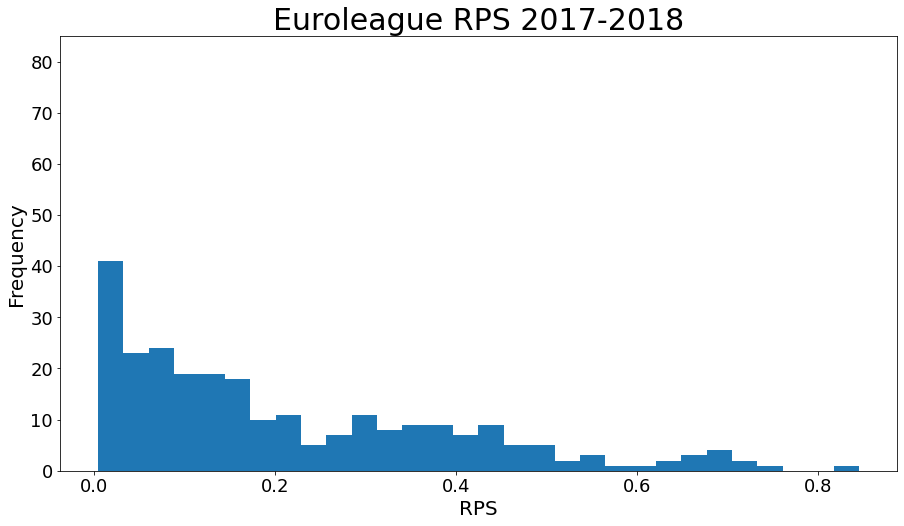

In [57]:
plt.figure(figsize=(15,8))

plt.hist(see_final_g["RPS"], 30, density=0)

plt.xlabel('RPS',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Euroleague RPS 2017-2018',fontsize=30)
plt.ylim(0,85)
plt.show()

# Eurocup

In [58]:
ec_baseline_data = baseline_data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]][baseline_data["Tournament"]=='Eurocup'].reset_index(drop = True)
ec_baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Eurocup,2013-10-15,Bonn,Alba Berlin,0.0,Alba Berlin,Regular Season
1,Eurocup,2013-10-15,Banvit,Kalev Cramo,1.0,Banvit,Regular Season
2,Eurocup,2013-10-15,PAOK,Buducnost,1.0,PAOK,Regular Season
3,Eurocup,2013-10-15,Bilbao,Cedevita,1.0,Bilbao,Regular Season
4,Eurocup,2013-10-15,Paris Levallois,Valencia,0.0,Valencia,Regular Season


In [59]:
ec_home = pd.get_dummies(ec_baseline_data["Home Team"]).reset_index(drop = True)
ec_away = -1*pd.get_dummies(ec_baseline_data["Away Team"]).reset_index(drop = True)
ec_x = pd.concat([ec_home,ec_away],axis=1).groupby(level=0, axis=1).sum()
ec_y = ec_baseline_data["Team Result"]

In [60]:
ec_x.head()

,AEK,ASVEL Villeurbanne,Alba Berlin,Alba Fehervar,Andorra,Aris,Armani Milano,Artland Dragons,Avtodor Saratov,Bamberg,Banvit,Bayern Munich,Besiktas,Bilbao,Bisons Loimaa,Bonn,Brindisi,Budivelnyk,Buducnost,Cantu,Cedevita,Chalon Saone,Cibona,Crvena Zvezda,Csu Asesoft Ploiesti,Darussafaka,Dijon,Dinamo Sassari,Fuenlabrada,Galatasaray,Gran Canaria,Gravelines,Hapoel Jerusalem,Igokea,Kalev Cramo,Khimik,Khimki,Krasny Oktyabr,Le Mans,Lietkabelis,Limoges,Lokomotiv Kuban,Ludwigsburg,Lukoil Academic,MZT Skopje,Maccabi Haifa,Maccabi Tel Aviv,Mons,Murcia,Nancy,Nanterre,Neptunas,Nizhny Novgorod,Nymburk,Oldenburg,Olimpija Ljubljana,Oostende,PAOK,Panionios,Paris Levallois,Partizan,Pinar Karsiyaka,Radnicki,Real Betis,Reggio Emilia,Rytas Vilnius,Siena,Spartak St Petersburg,Spirou Charleroi,Steaua Bucharest,Strasbourg,Szolnoki,Ted Ankara Kolejliler,Tofas Bursa,Trabzonspor,Trento,Turin,Turow Zgorzelec,Ulm,Unicaja Malaga,Unics Kazan,VEF Riga,Valencia,Varese,Venezia,Ventspils,Virtus Roma,Zaragoza,Zenit St Petersburg,Zielona Gora
0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0


In [61]:
x_train_ec=ec_x.iloc[:len(ec_baseline_data[ec_baseline_data["Match Date"]<"2017-08-01"])]
y_train_ec=ec_y.iloc[:len(ec_baseline_data[ec_baseline_data["Match Date"]<"2017-08-01"])]
x_test_ec=ec_x.iloc[len(ec_baseline_data[ec_baseline_data["Match Date"]<"2017-08-01"]):]
y_test_ec=ec_y.iloc[len(ec_baseline_data[ec_baseline_data["Match Date"]<"2017-08-01"]):]

###  Logistic Regression

In [62]:
lgr = LogisticRegression(solver='liblinear',C= 0.8479198446641489, penalty= 'l1').fit(x_train_ec, y_train_ec)
y_pre_proba_lgr=lgr.predict_proba(x_test_ec)
print("Logistic Regression")
print()
print("Test BS:",round(brier_score_loss(y_test_ec,y_pre_proba_lgr[:,1]),3))
print()
y_pre_lgr=np.where(pd.Series(y_pre_proba_lgr[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_lgr,y_test_ec),3))
print()
print("Test F1-score:",round(f1_score(y_pre_lgr,y_test_ec),3))


Logistic Regression

Test BS: 0.232

Test Accuracy: 0.636

Test F1-score: 0.717


In [63]:
coef_dict = {}
for coef, feat in zip(lgr.coef_[:].tolist()[0],ec_x.columns.values):
    coef_dict[feat] = coef
coef4=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef4=coef4.iloc[(-coef4[0].abs()).argsort()].reset_index()

In [64]:
sorted_coef4.head(50)

,index,0
0,MZT Skopje,-2.018550
1,Cibona,-1.894753
2,Khimki,1.722128
3,Artland Dragons,-1.688908
4,Lokomotiv Kuban,1.441214
5,Gran Canaria,1.388650
6,Bayern Munich,1.309841
7,Unics Kazan,1.305213
8,Valencia,1.265810
9,Brindisi,-1.167238


In [65]:
lgr.intercept_

array([0.54683345])

## Random Forest Classifier

In [66]:
rfc = RandomForestClassifier(max_depth= 38, max_features='sqrt', min_samples_leaf=0.0037012163422379674,
                             min_samples_split=0.251132570859313, n_estimators=41,
                             random_state=1).fit(x_train_ec, y_train_ec)

y_pre_proba_rfc=rfc.predict_proba(x_test_ec)
print("Random Forest Classifier")
print()
print("Test BS:",round(brier_score_loss(y_test_ec,y_pre_proba_rfc[:,1]),3))
print()
y_pre_rfc=np.where(y_pre_proba_rfc[:,1] > 0.5, 1, 0)
print("Test Accuracy:",round(accuracy_score(y_pre_rfc ,y_test_ec),3))
print()
print("Test F1-score:",round(f1_score(y_pre_rfc,y_test_ec),3))

Random Forest Classifier

Test BS: 0.237

Test Accuracy: 0.636

Test F1-score: 0.729


In [67]:
coef_dict = {}
for coef, feat in zip(rfc.feature_importances_[:].tolist(),ec_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()
sorted_coef2

,index,0
0,Gran Canaria,0.078277
1,Khimki,0.076719
2,Unics Kazan,0.070558
3,Lokomotiv Kuban,0.062643
4,Valencia,0.057309
5,Buducnost,0.042179
6,Artland Dragons,0.040209
7,Krasny Oktyabr,0.036797
8,Besiktas,0.035180
9,MZT Skopje,0.034169


## xgboost

In [68]:
alg = XGBClassifier(colsample_bytree= 0.5913621206231853, gamma= 4.08026456094463, learning_rate= 0.37903160103981465,
                    max_depth= 47, n_estimators= 94, reg_lambda= 0.11419103539605524, subsample= 0.7917278647223511,
                    objective='binary:logistic').fit(x_train_ec, y_train_ec)

y_pre_proba_alg=alg.predict_proba(x_test_ec)
print("xgboost")
print()
print("Test BS:",round(brier_score_loss(y_test_ec,y_pre_proba_alg[:,1]),3))
print()
y_pre_alg=np.where(y_pre_proba_alg[:,1] > 0.5, 1, 0)
print("Test Accuracy:",round(accuracy_score(y_pre_alg ,y_test_ec),3))
print()
print("Test F1-score:",round(f1_score(y_pre_alg,y_test_ec),3))


xgboost

Test BS: 0.238

Test Accuracy: 0.625

Test F1-score: 0.723


In [69]:
coef_dict = {}
for coef, feat in zip(alg.feature_importances_[:].tolist(),ec_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()
sorted_coef3

,index,0
0,Krasny Oktyabr,0.045282
1,Gran Canaria,0.036301
2,Lokomotiv Kuban,0.034154
3,Bayern Munich,0.034064
4,Bilbao,0.033864
5,Unics Kazan,0.031866
6,Cantu,0.030599
7,Valencia,0.030558
8,Artland Dragons,0.030412
9,Le Mans,0.029568


In [70]:
ens_proba=(y_pre_proba_lgr[:,1]+y_pre_proba_rfc[:,1]+y_pre_proba_alg[:,1])/3


print("------Ensemble 3 classifier-------")
print()
print("Test BS:",round(brier_score_loss(y_test_ec,ens_proba),3))
print()
y_pre_ens=np.where(pd.Series(ens_proba)>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test_ec),3))
print()
print("Test F1-score:",round(f1_score(y_pre_ens,y_test_ec),3))


------Ensemble 3 classifier-------

Test BS: 0.232

Test Accuracy: 0.625

Test F1-score: 0.721


In [71]:
pd.options.display.max_rows = None
see_final_g=ec_baseline_data[["Home Team","Away Team","Team Result"]][ec_baseline_data["Match Date"]>"2017-08-01"]
see_final_g["prediction probability"]=ens_proba
see_final_g["RPS"]=(see_final_g["Team Result"]-see_final_g["prediction probability"])**2
see_final_g[see_final_g["RPS"]>0.5]

,Home Team,Away Team,Team Result,prediction probability,RPS
1133,Hapoel Jerusalem,Buducnost,0.0,0.871386,0.759314
1145,Bilbao,Partizan,0.0,0.710074,0.504205
1156,Trento,Tofas Bursa,0.0,0.728002,0.529987
1160,Galatasaray,Lietkabelis,0.0,0.810212,0.656444
1205,Zenit St Petersburg,ASVEL Villeurbanne,0.0,0.755290,0.570463
1206,Alba Berlin,Limoges,0.0,0.721327,0.520313
1215,Unics Kazan,Darussafaka,0.0,0.807361,0.651831
1227,Hapoel Jerusalem,Reggio Emilia,0.0,0.740059,0.547687
1238,Gran Canaria,ASVEL Villeurbanne,0.0,0.838178,0.702543
1246,Galatasaray,Darussafaka,0.0,0.813598,0.661942


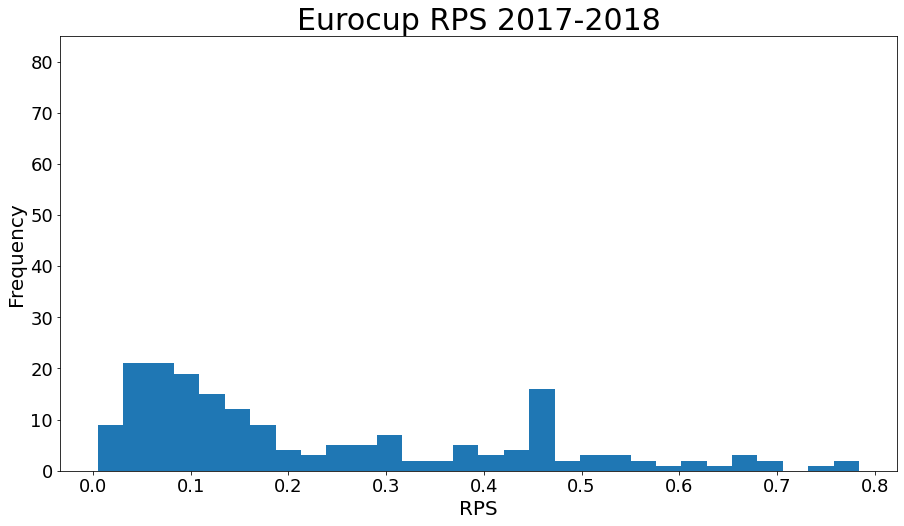

In [72]:
plt.figure(figsize=(15,8))



plt.hist(see_final_g["RPS"], 30, density=0)

plt.xlabel('RPS',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Eurocup RPS 2017-2018',fontsize=30)
plt.ylim(0,85)
plt.show()